In [49]:
import webbrowser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.indicators.hv import Hypervolume
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.visualization.pcp import PCP

from evolution.outcomes.outcome_manager import OutcomeManager
from enroads_runner import EnroadsRunner


In [50]:
actions = [
        "_source_subsidy_delivered_coal_tce",
        "_source_subsidy_start_time_delivered_coal",
        "_source_subsidy_stop_time_delivered_coal",
        "_no_new_coal",
        "_year_of_no_new_capacity_coal",
        "_utilization_adjustment_factor_delivered_coal",
        "_utilization_policy_start_time_delivered_coal",
        "_utilization_policy_stop_time_delivered_coal",
        "_target_accelerated_retirement_rate_electric_coal",
        "_source_subsidy_delivered_oil_boe",
        "_source_subsidy_start_time_delivered_oil",
        "_source_subsidy_stop_time_delivered_oil",
        "_no_new_oil",
        "_year_of_no_new_capacity_oil",
        "_utilization_adjustment_factor_delivered_oil",
        "_utilization_policy_start_time_delivered_oil",
        "_utilization_policy_stop_time_delivered_oil",
        "_source_subsidy_delivered_gas_mcf",
        "_source_subsidy_start_time_delivered_gas",
        "_source_subsidy_stop_time_delivered_gas",
        "_no_new_gas",
        "_year_of_no_new_capacity_gas",
        "_utilization_adjustment_factor_delivered_gas",
        "_utilization_policy_start_time_delivered_gas",
        "_utilization_policy_stop_time_delivered_gas",
        "_source_subsidy_renewables_kwh",
        "_source_subsidy_start_time_renewables",
        "_source_subsidy_stop_time_renewables",
        "_use_subsidies_by_feedstock",
        "_source_subsidy_delivered_bio_boe",
        "_source_subsidy_start_time_delivered_bio",
        "_source_subsidy_stop_time_delivered_bio",
        "_no_new_bio",
        "_year_of_no_new_capacity_bio",
        "_wood_feedstock_subsidy_boe",
        "_crop_feedstock_subsidy_boe",
        "_other_feedstock_subsidy_boe",
        "_source_subsidy_nuclear_kwh",
        "_source_subsidy_start_time_nuclear",
        "_source_subsidy_stop_time_nuclear",
        "_carbon_tax_initial_target",
        "_carbon_tax_phase_1_start",
        "_carbon_tax_time_to_achieve_initial_target",
        "_carbon_tax_final_target",
        "_carbon_tax_phase_3_start",
        "_carbon_tax_time_to_achieve_final_target",
        "_apply_carbon_tax_to_biofuels",
        "_ccs_carbon_tax_qualifier",
        "_qualifying_path_renewables",
        "_qualifying_path_nuclear",
        "_qualifying_path_new_zero_carbon",
        "_qualifying_path_beccs",
        "_qualifying_path_bioenergy",
        "_qualifying_path_fossil_ccs",
        "_qualifying_path_gas",
        "_electric_standard_active",
        "_electric_standard_target",
        "_electric_standard_start_year",
        "_electric_standard_target_time",
        "_emissions_performance_standard",
        "_performance_standard_time"
    ]

outcomes = ["Temperature above 1.5C", "Max cost of energy"]

In [51]:
class CustomProblem(ElementwiseProblem):
    def __init__(self, actions: list[str], outcomes: list[str]):
        self.input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
        xl = np.zeros(len(actions))
        xu = np.ones(len(actions))
        switch_idxs = []
        switchl = []
        switchu = []
        self.start_year_idxs = set()
        for i, action in enumerate(actions):
            row = self.input_specs[self.input_specs["varId"] == action].iloc[0]
            if row["kind"] == "slider":
                xl[i] = row["minValue"]
                xu[i] = row["maxValue"]
                if "start_time" in action and "stop_time" in actions[i+1]:
                    self.start_year_idxs.add(i)
            else:
                switch_idxs.append(i)
                switchl.append(row["offValue"])
                switchu.append(row["onValue"])

        super().__init__(n_var=len(actions), n_obj=len(outcomes), n_ieq_constr=len(self.start_year_idxs), xl=xl, xu=xu)

        # To evaluate candidate solutions
        self.runner = EnroadsRunner("temp")
        self.actions = [action for action in actions]
        self.outcomes = [outcome for outcome in outcomes]
        self.outcome_manager = OutcomeManager(outcomes)

        # To parse switches
        self.switch_idxs = switch_idxs
        self.switchl = switchl
        self.switchu = switchu
        

    def parse_switches(self, x):
        parsed = x.copy()
        parsed[self.switch_idxs] = np.where(parsed[self.switch_idxs] < 0.5, self.switchl, self.switchu)
        return parsed

    def _evaluate(self, x, out, *args, **kwargs):
        parsed = self.parse_switches(x)
        actions_dict = dict(zip(self.actions, parsed))
        outcomes_df = self.runner.evaluate_actions(actions_dict)
        results_dict = self.outcome_manager.process_outcomes(actions_dict, outcomes_df)
        f = []
        for outcome in self.outcomes:
            f.append(results_dict[outcome])

        g = [x[idx] - x[idx+1] for idx in self.start_year_idxs]

        out["F"] = f
        out["G"] = g

problem = CustomProblem(actions, outcomes)

make: `enroads' is up to date.


In [52]:
algorithm = NSGA2(
    pop_size=100,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    survival=RankAndCrowding(crowding_func="mnn"),
    eliminate_duplicates=True
)

In [53]:
res = minimize(problem, algorithm, get_termination("n_gen", 30), seed=42, save_history=True, verbose=True)
X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.396355E+01 |  1.164905E+02 |             - |             -
     2 |      200 |      1 |  3.3019329798 |  6.244570E+01 |             - |             -
     3 |      300 |      1 |  0.3002496098 |  3.880945E+01 |             - |             -
     4 |      400 |      5 |  0.000000E+00 |  1.705888E+01 |             - |             -
     5 |      500 |      6 |  0.000000E+00 |  5.3921606628 |  0.1044030809 |         ideal
     6 |      600 |      8 |  0.000000E+00 |  0.6198731874 |  0.0700466978 |         ideal
     7 |      700 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1310530888 |         ideal
     8 |      800 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1294606150 |         ideal
     9 |      900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0099766370 |         ideal
    10 |     1000 |      4 |  0.000000E+00 |  0.000000E+00 |  0.2541724519 |         ideal

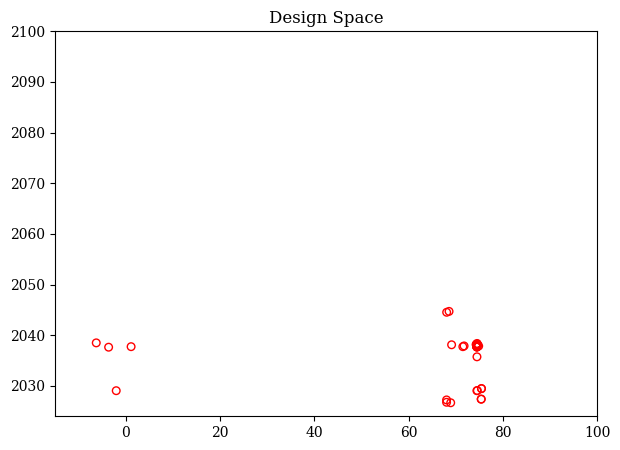

In [54]:
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

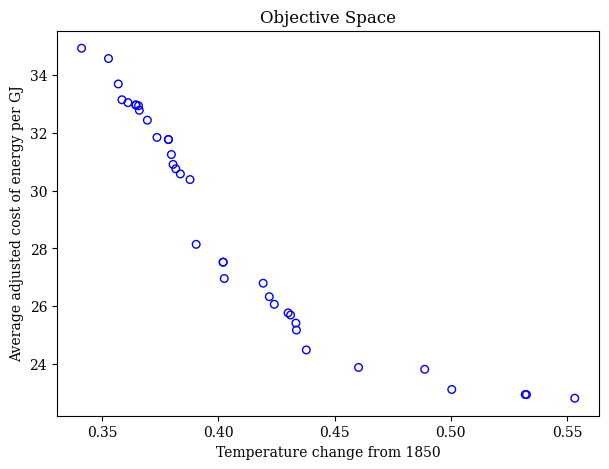

In [55]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("Temperature change from 1850")
plt.ylabel("Average adjusted cost of energy per GJ")
plt.show()

In [56]:
sample_idxs = set()
for i in range(F.shape[1]):
    sample_idxs.add(F[:,i].argmin())
    sample_idxs.add(F[:,i].argmax())

sample_idxs = list(sample_idxs)
sample_idxs

[11, 31]

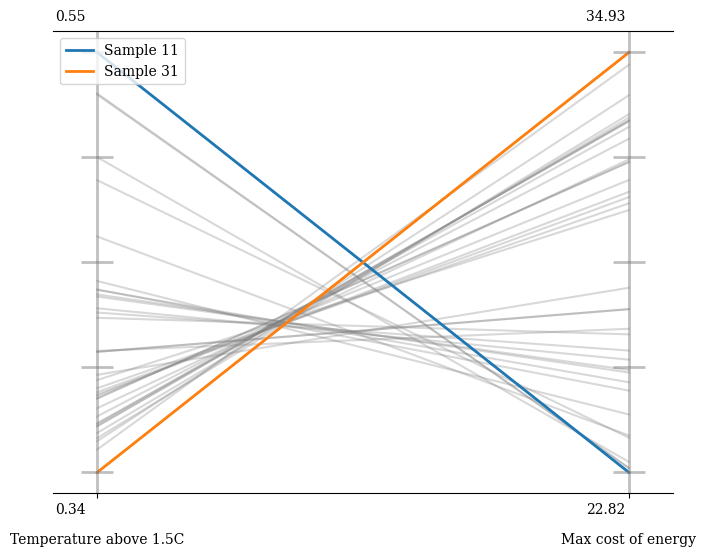

In [57]:
matplotlib_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
plot = PCP(labels=outcomes, legend=(True, {'loc': "upper left"}))
plot.set_axis_style(color="grey", alpha=0.5)
plot.add(F, color="grey", alpha=0.3)
for idx, color in zip(sample_idxs, matplotlib_colors):
    plot.add(F[idx], color=color, linewidth=2, label=f"Sample {idx}")
plot.show()

In [58]:
def extract_history(res):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

Whole population feasible in Generation 6 after 700 evaluations.


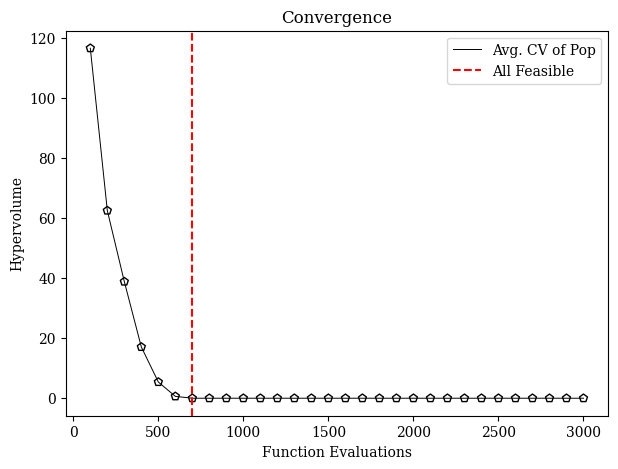

In [59]:
n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

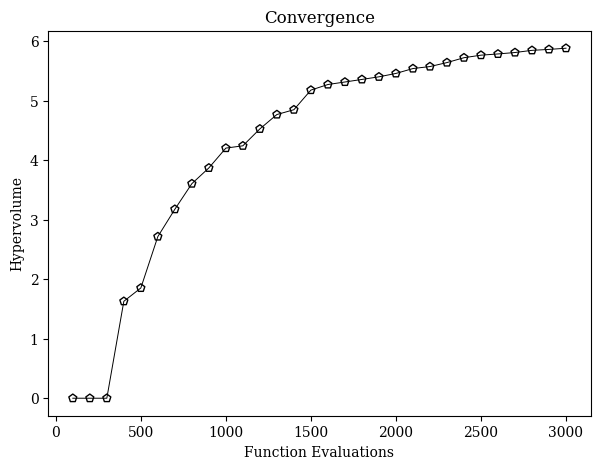

In [73]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

In [61]:
def actions_to_url(actions_dict: dict[str, float]) -> str:
    """
    Converts an actions dict to a URL.
    """
    # Parse actions into format for URL
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
    id_vals = {}
    for action, val in actions_dict.items():
        row = input_specs[input_specs["varId"] == action].iloc[0]
        id_vals[row["id"]] = val

    template = "https://en-roads.climateinteractive.org/scenario.html?v=24.6.0"
    for key, val in id_vals.items():
        template += f"&p{key}={val}"

    return template

In [62]:
actions_dict = dict(zip(actions, problem.parse_switches(X[0])))
webbrowser.open(actions_to_url(actions_dict))

True